# Instalación del programa en python

In [ ]:
# Install dependencies
%pip install -q amplpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 7.8 MB/s eta 0:00:00


### Google colab & Kaggle integration

In [ ]:
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

# Modelo

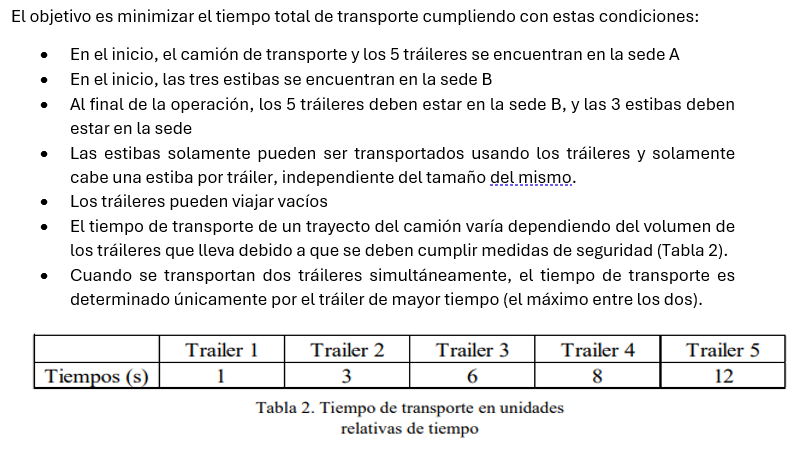

## Especificación

In [ ]:
%%ampl_eval
reset; # limpiar definiciones anteriores
# definir el conjunto de traileres
set T;

# definir el conjunto de estibas
set E;

# definir los tiempos de transporte al llevar el trailer t1,t2
# (t1 puede ser igual a t2)
param time{T, T};

# definir las variables de decision:
# x[T, T] Cantidad de viajes de los trailers
var x{T, T} >= 0 integer;

# y[T, E] viajes de la estiba e por el trailer t
var y{T, E} binary;

# La función objetivo es minimizar el tiempo de transporte siguiendo las condiciones
minimize min_tiempo: sum{t1 in T, t2 in T} x[t1,t2]*time[t1,t2] + sum{t in T, e in E} y[t,e]*time[t,t];

# restricciones:

# todos los trailers deben llegar a B
subject to trailers_a_B {t1 in T}: sum{t2 in T} (x[t1,t2] + x[t2,t1]) - x[t1,t1]  >= 1;

# Todas las estibas deben llegar a A
subject to estibas_a_A {e in E}: sum{t in T} y[t,e] = 1;

# Todos los trailers deben si o si llegar a B
subject to trailer_siosi_en_B {t1 in T}: sum{t2 in T} (x[t1,t2] + x[t2,t1]) - x[t1,t1] = 1 + sum{e in E} y[t1,e];

## Inicialización

In [ ]:
import numpy as np
import pandas as pd

#Inicializando los conjuntos
ampl.set["T"] = [i+1 for i in range(5)]
ampl.set["E"] = [i+1 for i in range(3)]

#Inicializando los parametros
t = [1, 3, 6, 8, 12]

times = [[max(t[i], t[j]) for j in range(5)] for i in range(5)]

time_df = pd.DataFrame(
    {
        1: times[0],
        2: times[1],
        3: times[2],
        4: times[3],
        5: times[4]
    },
    index = list(ampl.set["T"])
)


ampl.param["time"] = time_df
time_df

,1,2,3,4,5
1,1,3,6,8,12
2,3,3,6,8,12
3,6,6,6,8,12
4,8,8,8,8,12
5,12,12,12,12,12


## Solución Optima

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()


solution_x = ampl.get_data("x")
solution_y = ampl.get_data("y")

print(f"Solución:\n\t{solution_x}")
print(f"Solución:\n\t{solution_y}")

print("\nPara minimizar el tiempo:")
for t1, t2, res in solution_x:
  if res != 0:
    if t1 != t2:
      if res == 1: print(f"-Los trailers {t1} y {t2} son transportados juntos: {res} vez a B.")
      else: print(f"-Los trailers {t1} y {t2} son transportados juntos: {res} veces a B.")
    else:
      if res == 1: print(f"-El trailer {t1} es transportado solo: {res} vez a B.")
      else: print(f"-El trailer {t1} es transportado solo: {res} veces a B.")

for t, e, res in solution_y:
  if res != 0: print(f"El trailer {t} lleva la estiba {e} a A.")

Gurobi 11.0.1: Gurobi 11.0.1: optimal solution; objective 25
5 simplex iterations
1 branching node
Solución:
	   index0       index1    |      x      
     1              1       |      4      
     1              2       |      0      
     1              3       |      0      
     1              4       |      0      
     1              5       |      0      
     2              1       |      0      
     2              2       |      0      
     2              3       |      1      
     2              4       |      0      
     2              5       |      0      
     3              1       |      0      
     3              2       |      0      
     3              3       |      0      
     3              4       |      0      
     3              5       |      0      
     4              1       |      0      
     4              2       |      0      
     4              3       |      0      
     4              4       |      0      
     4           